In [1]:
import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
path = kagglehub.dataset_download("zeeshier/weather-forecast-dataset")

print("Path to dataset files:", path)

files = os.listdir(path)
print("Files in dataset folder:", files)

csv_file = [f for f in files if f.endswith('.csv')][0]
csv_path = os.path.join(path, csv_file)
print("csv_path", csv_path)

100%|██████████| 114k/114k [00:00<00:00, 566kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/zeeshier/weather-forecast-dataset/versions/1
Files in dataset folder: ['weather_forecast_data.csv']
csv_path /root/.cache/kagglehub/datasets/zeeshier/weather-forecast-dataset/versions/1/weather_forecast_data.csv


In [4]:
my_dataframe = pd.read_csv(csv_path)
my_dataframe.head(10)

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
0,23.720338,89.592641,7.335604,50.501694,1032.378759,rain
1,27.879734,46.489704,5.952484,4.990053,992.614190,no rain
2,25.069084,83.072843,1.371992,14.855784,1007.231620,no rain
3,23.622080,74.367758,7.050551,67.255282,982.632013,rain
4,20.591370,96.858822,4.643921,47.676444,980.825142,no rain
5,26.147353,48.217260,15.258547,59.766279,1049.738751,no rain
6,20.939680,40.799444,2.232566,45.827508,1014.173766,no rain
7,32.294325,51.848471,2.873621,92.551497,1006.041733,no rain
8,34.091569,48.057114,5.570206,82.524873,993.732047,no rain
9,19.586038,82.978293,5.760537,98.014450,1036.503457,rain


In [5]:
my_dataframe['Rain']

,Rain
0,rain
1,no rain
2,no rain
3,rain
4,no rain
...,...
2495,no rain
2496,no rain
2497,no rain
2498,no rain


In [6]:
n = len(pd.unique(my_dataframe['Rain']))
unique_values = my_dataframe['Rain'].unique()

print(n)
print(unique_values)

2
['rain' 'no rain']


In [7]:
our_rain_mapping = {
    'no rain': 0,
    'rain': 1
}

In [8]:
my_dataframe['Rain'] = my_dataframe['Rain'].map(our_rain_mapping)
my_dataframe['Rain']

,Rain
0,1
1,0
2,0
3,1
4,0
...,...
2495,0
2496,0
2497,0
2498,0


In [9]:
my_dataframe.info()
my_dataframe.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  2500 non-null   float64
 1   Humidity     2500 non-null   float64
 2   Wind_Speed   2500 non-null   float64
 3   Cloud_Cover  2500 non-null   float64
 4   Pressure     2500 non-null   float64
 5   Rain         2500 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 117.3 KB


,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
0,23.720338,89.592641,7.335604,50.501694,1032.378759,1
1,27.879734,46.489704,5.952484,4.990053,992.614190,0
2,25.069084,83.072843,1.371992,14.855784,1007.231620,0
3,23.622080,74.367758,7.050551,67.255282,982.632013,1
4,20.591370,96.858822,4.643921,47.676444,980.825142,0
5,26.147353,48.217260,15.258547,59.766279,1049.738751,0
6,20.939680,40.799444,2.232566,45.827508,1014.173766,0
7,32.294325,51.848471,2.873621,92.551497,1006.041733,0
8,34.091569,48.057114,5.570206,82.524873,993.732047,0
9,19.586038,82.978293,5.760537,98.014450,1036.503457,1


In [10]:
my_dataframe.describe()

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,22.581725,64.347094,9.906255,49.658104,1014.312336,0.125600
std,7.326996,19.954739,5.780316,29.123104,20.196433,0.331464
min,10.001842,30.005071,0.009819,0.015038,980.014486,0.000000
25%,16.359398,47.339815,4.761909,23.900016,996.938630,0.000000
50%,22.536448,63.920797,9.908572,49.488284,1013.433035,0.000000
75%,28.976476,81.561021,14.948408,75.324140,1031.735067,0.000000
max,34.995214,99.997481,19.999132,99.997795,1049.985593,1.000000


In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [12]:
scaler = MinMaxScaler() # usual Norm [0, 1]
# or
scaler = MinMaxScaler(feature_range=(-1, 1)) # Norm [-1, 1]
normalized_data = scaler.fit_transform(my_dataframe)

df_normalized = pd.DataFrame(normalized_data, columns=my_dataframe.columns)
df_normalized.head()

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
0,0.097771,0.702687,-0.267030,0.009907,0.496740,1.0
1,0.430611,-0.528959,-0.405416,-0.900483,-0.639860,-1.0
2,0.205699,0.516386,-0.863710,-0.703134,-0.222047,-1.0
3,0.089908,0.267643,-0.295550,0.345037,-0.925183,1.0
4,-0.152613,0.910314,-0.536342,-0.046607,-0.976829,-1.0


In [13]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(my_dataframe)

df_scaled = pd.DataFrame(scaled_data, columns=my_dataframe.columns)
df_scaled.head()

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
0,0.155431,1.265393,-0.444814,0.028972,0.894714,2.638519
1,0.723225,-0.895074,-0.684143,-1.534074,-1.074570,-0.379000
2,0.339547,0.938599,-1.476731,-1.195246,-0.350663,-0.379000
3,0.142018,0.502270,-0.494138,0.604355,-1.568924,2.638519
4,-0.271701,1.629599,-0.910571,-0.068058,-1.658406,-0.379000


In [14]:
train_data, test_data = train_test_split(df_normalized, test_size=0.2, random_state=42)
eval_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

In [15]:
desired_df = my_dataframe[['Temperature', 'Humidity','Rain']].copy()
desired_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  2500 non-null   float64
 1   Humidity     2500 non-null   float64
 2   Rain         2500 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 58.7 KB


In [16]:
feature_columns = ['Temperature', 'Humidity']
label_column = ['Rain']

# Extract features and label
features = desired_df[feature_columns].values
labels = desired_df[label_column].values

In [17]:
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

In [18]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_val_scaled = scaler.transform(X_val)

# Convert scaled data and labels to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_eval_tensor = torch.tensor(y_val, dtype=torch.float32)

In [19]:
class BinaryClassifier(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(BinaryClassifier, self).__init__()
        self.linear1 = nn.Linear(2, 3)
        self.linear4 = nn.Linear(3, 1)
        self.dropout = nn.Dropout(p=dropout_rate) # Dropout layer

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x) # Apply dropout after the ReLU activation
        logits = self.linear4(x) # Logits (raw scores, unnormalized/no activation)
        x = torch.sigmoid(logits)
        return x

In [20]:
#Hyperparameters
learning_rate = 0.0001
num_epochs = 3000
batch_size = 150
dropout_rate = 0.2

In [21]:
binary_model_module = BinaryClassifier()

In [22]:
# Create a TensorDataset
training_dataset = TensorDataset(X_train_tensor, y_train_tensor)
validation_dataset = TensorDataset(X_val_tensor, y_eval_tensor)

# Create a DataLoader
training_data_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)  # shuffle=True shuffles the data each epoch
validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)  # shuffle=True shuffles the data each epoch

In [23]:
#Training cycle
criterion = nn.BCELoss()
optimizer = optim.SGD(binary_model_module.parameters(), lr=learning_rate)

In [24]:
train_losses = []
eval_losses = []
train_accuracy = []
val_accuracy = []

binary_model_module.train()
for epoch in range(num_epochs):  # Train for 10 epochs
    epoch_train_loss = 0
    correct_train_preds = 0  # Track correct predictions during training
    total_train_preds = 0    # Track total predictions during training

    for batch_features, batch_labels in training_data_loader:
        outputs = binary_model_module(batch_features)
        loss = criterion(outputs, batch_labels)
        epoch_train_loss += loss.item()

        # Accuracy calculation: Get predicted class (0 or 1 for binary classification)
        predicted_labels = (outputs > 0.5).float()  # Assuming binary output with sigmoid activation
        correct_train_preds += (predicted_labels == batch_labels).sum().item()
        total_train_preds += batch_labels.size(0)

        # Clear gradients (gradients managed by the Optimizer) just before computing new gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()};")

    train_losses.append(epoch_train_loss / len(training_data_loader))
    train_accuracy.append(correct_train_preds / total_train_preds)  # Calculate accuracy

    # Evaluate the model on the validation set (you'll need a separate validation DataLoader)
    binary_model_module.eval()  # Set model to evaluation mode
    epoch_eval_loss = 0
    correct_eval_preds = 0  # Track correct predictions during validation
    total_eval_preds = 0    # Track total predictions during validation

    with torch.no_grad():  # Disable gradient calculation during evaluation
        for batch_features, batch_labels in validation_data_loader:
            outputs = binary_model_module(batch_features)
            loss = criterion(outputs, batch_labels)
            epoch_eval_loss += loss.item()

            # Accuracy calculation for validation set
            predicted_labels = (outputs > 0.5).float()
            correct_eval_preds += (predicted_labels == batch_labels).sum().item()
            total_eval_preds += batch_labels.size(0)

    eval_losses.append(epoch_eval_loss / len(validation_data_loader))
    val_accuracy.append(correct_eval_preds / total_eval_preds)  # Calculate accuracy

print(f" ====> Done Training in {num_epochs} epochs!")

Epoch 1/3000, Loss: 0.9266418218612671;
Epoch 1/3000, Loss: 0.927045464515686;
Epoch 1/3000, Loss: 0.9615063667297363;
Epoch 1/3000, Loss: 0.9632051587104797;
Epoch 1/3000, Loss: 1.0128388404846191;
Epoch 1/3000, Loss: 0.9872178435325623;
Epoch 1/3000, Loss: 0.9918212890625;
Epoch 1/3000, Loss: 0.9436522126197815;
Epoch 1/3000, Loss: 0.992174506187439;
Epoch 1/3000, Loss: 0.9920461773872375;
Epoch 1/3000, Loss: 0.9757173657417297;
Epoch 1/3000, Loss: 0.9584123492240906;
Epoch 1/3000, Loss: 0.945859968662262;
Epoch 1/3000, Loss: 0.9195120334625244;
Epoch 11/3000, Loss: 0.9352480173110962;
Epoch 11/3000, Loss: 0.990086555480957;
Epoch 11/3000, Loss: 1.0058256387710571;
Epoch 11/3000, Loss: 0.9586288332939148;
Epoch 11/3000, Loss: 0.9517183303833008;
Epoch 11/3000, Loss: 0.9915754199028015;
Epoch 11/3000, Loss: 0.9519067406654358;
Epoch 11/3000, Loss: 0.9578607082366943;
Epoch 11/3000, Loss: 0.9735974073410034;
Epoch 11/3000, Loss: 0.9413661956787109;
Epoch 11/3000, Loss: 0.90363842248916

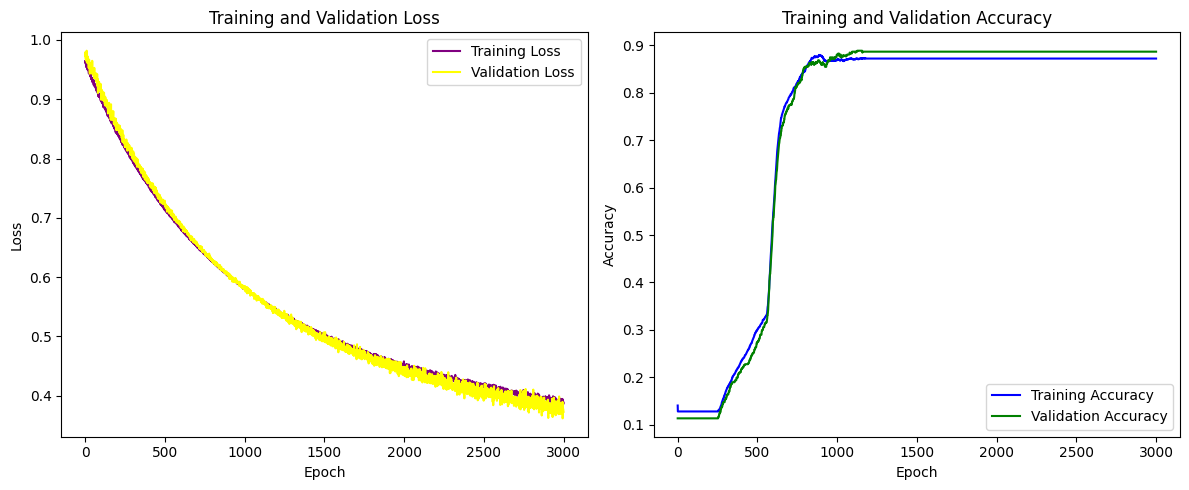

In [25]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss
axs[0].plot(train_losses, label='Training Loss', color='purple')
axs[0].plot(eval_losses, label='Validation Loss', color='Yellow')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].legend()

# Plot Accuracy
axs[1].plot(train_accuracy, label='Training Accuracy', color='blue')
axs[1].plot(val_accuracy, label='Validation Accuracy', color='green')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

[[443   0]
 [ 57   0]]


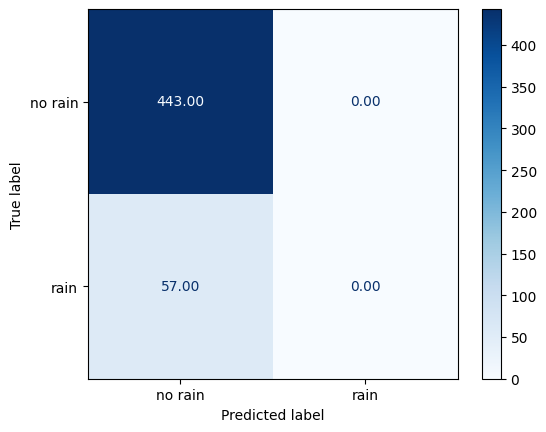

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Step 1: Use the model to make predictions (convert probabilities to binary outputs)
binary_model_module.eval()  # Set the model to evaluation mode # Changed 'binary_classifier_model' to 'binary_model_module'
with torch.no_grad():
    y_pred_prob = binary_model_module(X_val_tensor) # Changed 'binary_classifier_model' to 'binary_model_module'
    y_pred = (y_pred_prob > 0.5).type(torch.float)

    # # Step 2: Generate the confusion matrix
    cm = confusion_matrix(y_eval_tensor.cpu().numpy(), y_pred.cpu().numpy())  # Convert tensors to NumPy arrays
    print(cm)

    # Step 3: Visualize the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no rain", "rain"])
    disp.plot(cmap="Blues", values_format=".2f", ax=None, xticks_rotation="horizontal")